In [49]:
#Import necessary libraries and dependencies
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [50]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the dataset in your Google Drive
dataset_path = '/content/emotions_dataset.csv'

# Load the dataset
import pandas as pd
data = pd.read_csv(dataset_path)

# Display dataset information
print("Dataset Overview:")
print(data.head())
print("\nDataset Info:")
print(data.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Overview:
                                                text    label
0      i just feel really helpless and heavy hearted     fear
1  ive enjoyed being able to slouch about relax a...  sadness
2  i gave up my internship with the dmrg and am f...     fear
3                         i dont know i feel so lost  sadness
4  i am a kindergarten teacher and i am thoroughl...     fear

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  object
dtypes: object(2)
memory usage: 6.4+ MB
None


In [51]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
text     0
label    0
dtype: int64


In [52]:
# Separate the input texts and labels
texts = data['text']  # Replace 'text' with the name of your text column
labels = data['label']  # Replace 'label' with the name of your label column

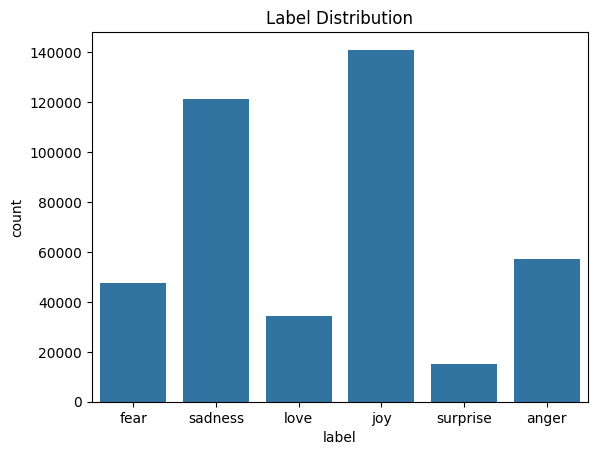

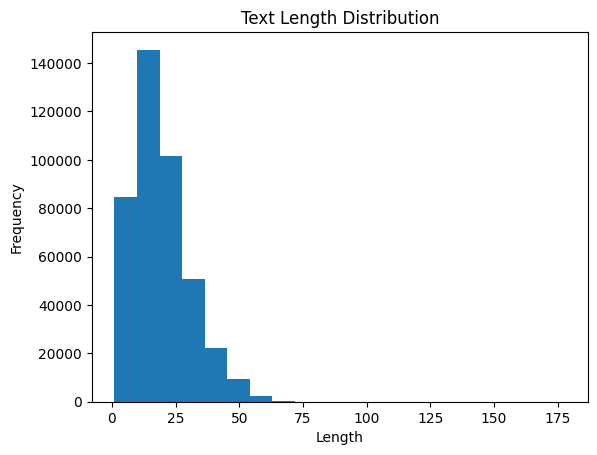

In [53]:
# Plot label distribution
sns.countplot(x=labels)
plt.title("Label Distribution")
plt.show()

# Plot text length distribution
text_lengths = [len(text.split()) for text in texts]
plt.hist(text_lengths, bins=20)
plt.title("Text Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [54]:
# Encode labels (if they are categorical strings)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

In [55]:
# Tokenize and convert texts to sequences
tokenizer = Tokenizer(num_words=10000)  # Use the most frequent 10,000 words
tokenizer.fit_on_texts(texts)
X_sequences = tokenizer.texts_to_sequences(texts)

In [56]:
# Pad sequences to ensure uniform input length
max_length = 100  # Adjust based on the average length of your text data
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post')

In [57]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

In [58]:
# Define vocab_size
vocab_size = len(tokenizer.word_index) + 1  # +1 for the padding token (0)

In [59]:
# 3. Define the Model
model = Sequential([
    # Embedding layer with fewer dimensions (e.g., 50 instead of 128)
    Embedding(input_dim=10000, output_dim=50, input_length=100),

    # Global Average Pooling instead of LSTM or GRU for speed
    GlobalAveragePooling1D(),

    Dense(64, activation='relu'),
    Dropout(0.3),  # Add dropout to prevent overfitting
    Dense(32, activation='relu'),
    Dropout(0.3),  # Add another dropout layer

    # Output layer (adjust units for the number of classes in your dataset)
    Dense(len(set(y_train)), activation='softmax')
])

# Compile the model with a simpler optimizer
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_6           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Extend epochs for better training
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.5106 - loss: 1.2062 - val_accuracy: 0.8460 - val_loss: 0.4565 - learning_rate: 0.0010
Epoch 2/20
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8557 - loss: 0.4221 - val_accuracy: 0.8642 - val_loss: 0.3766 - learning_rate: 0.0010
Epoch 3/20
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8876 - loss: 0.3154 - val_accuracy: 0.8938 - val_loss: 0.2460 - learning_rate: 0.0010
Epoch 4/20
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.8969 - loss: 0.2651 - val_accuracy: 0.9022 - val_loss: 0.2129 - learning_rate: 0.0010
Epoch 5/20
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9015 - loss: 0.2393 - val_accuracy: 0.9038 - val_loss: 0.2019 - learning_rate: 0.0010
Epoch 6/20
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9048 - loss: 0.2202 - val_accuracy: 0.9006 - val_loss: 0.2359 - learning_rate: 0.0010
Epoch 7/20
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9

In [61]:
# Evaluate the Model
# Assuming X_train and X_val are already padded, use them directly:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Training Accuracy: 0.9165, Validation Accuracy: 0.9038
Training Loss: 0.1652, Validation Loss: 0.2019


2606/2606 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


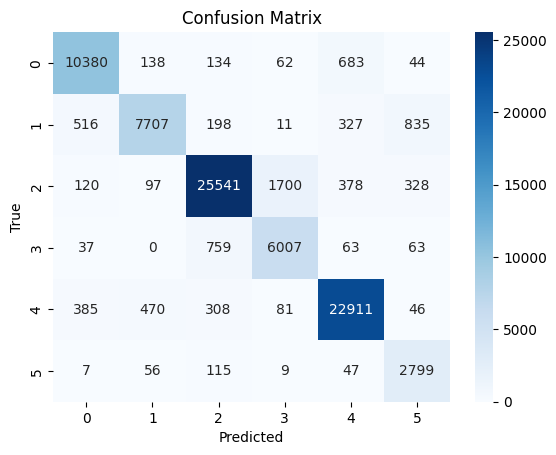

              precision    recall  f1-score   support

       anger       0.91      0.91      0.91     11441
        fear       0.91      0.80      0.85      9594
         joy       0.94      0.91      0.93     28164
        love       0.76      0.87      0.81      6929
     sadness       0.94      0.95      0.94     24201
    surprise       0.68      0.92      0.78      3033

    accuracy                           0.90     83362
   macro avg       0.86      0.89      0.87     83362
weighted avg       0.91      0.90      0.90     83362



In [62]:
# Predict on validation data
y_pred = model.predict(X_val).argmax(axis=1)

# Get unique labels from y_train (or y_val) to ensure consistency
unique_labels = sorted(set(y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Generate classification report using unique labels
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_[unique_labels]))

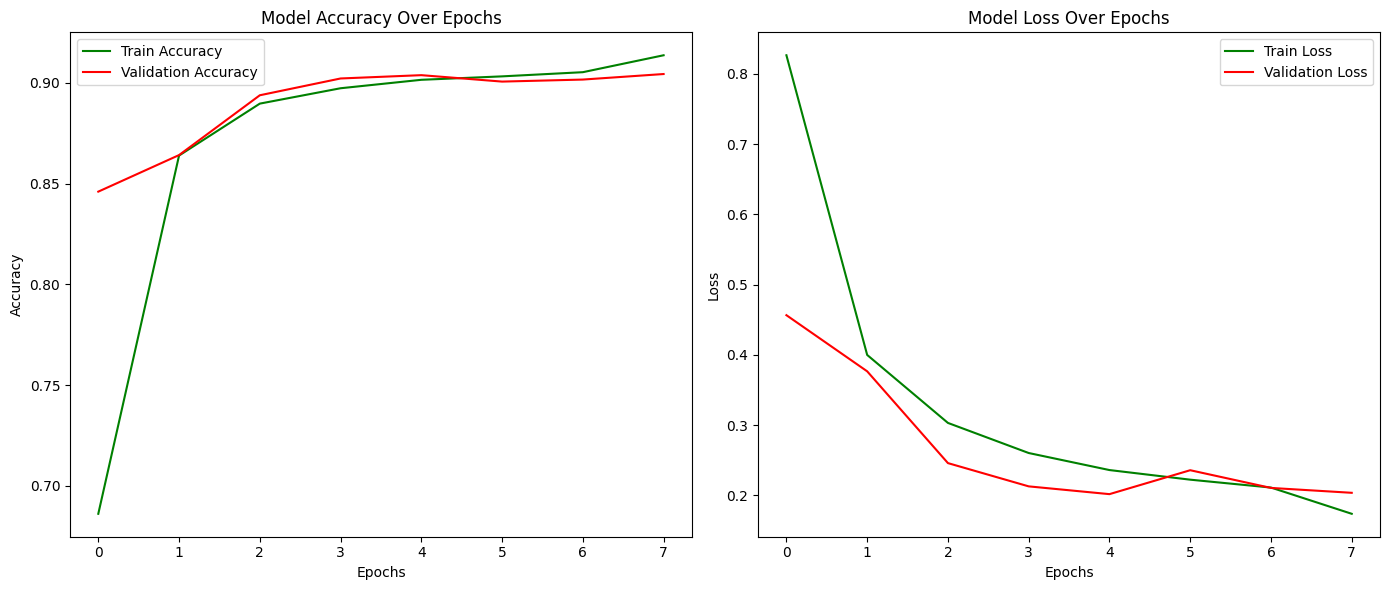

In [63]:
# Plot Training and Validation Curves
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()